## 1. EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from functools import partial
import plotnine
from plotnine import *

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [3]:
test_df = (orders[orders['eval_set']=='test']
          .reset_index()
          .drop(['index', 'eval_set'], axis=1))

In [4]:
prior_df = (orders[orders['eval_set']=='prior']
          .reset_index()
          .drop(['index', 'eval_set'], axis=1))

In [5]:
train_df = (orders[orders['eval_set']=='train']
          .reset_index()
          .drop(['index', 'eval_set'], axis=1))

In [6]:
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')

In [7]:
goods.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


In [8]:
dep = (goods.groupby('department').count()['product_id']
              .sort_values(ascending=False).to_frame()
              .reset_index())
dep

,department,product_id
0,personal care,6563
1,snacks,6264
2,pantry,5371
3,beverages,4365
4,frozen,4007
5,dairy eggs,3449
6,household,3085
7,canned goods,2092
8,dry goods pasta,1858
9,produce,1684


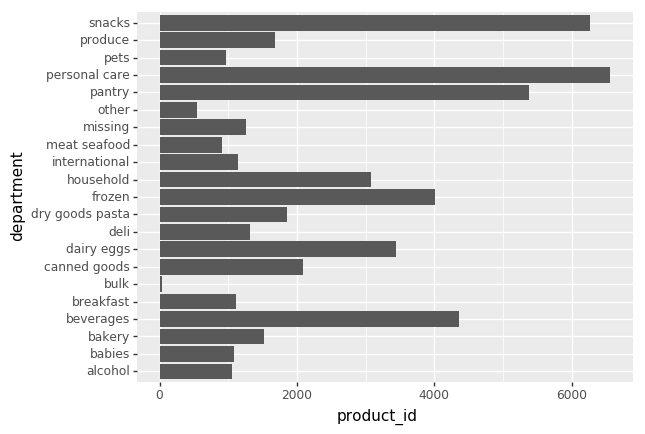

<ggplot: (8756156540406)>

In [9]:
# 각 Department에 상품이 몇 개씩 있는가 -> 상품이 많으면 그 department가 쇼핑 목록에 들어갈 확률이 높아진다.
(
    ggplot(dep, aes('department', 'product_id'))
     +geom_bar(stat='identity')
     +coord_flip()
)

In [10]:
part_aisle = (goods.groupby('aisle').count()['product_id']
              .sort_values(ascending=False)[:15].to_frame()
              .reset_index())
part_aisle

,aisle,product_id
0,missing,1258
1,candy chocolate,1246
2,ice cream ice,1091
3,vitamins supplements,1038
4,yogurt,1026
5,chips pretzels,989
6,tea,894
7,packaged cheese,891
8,frozen meals,880
9,cookies cakes,874


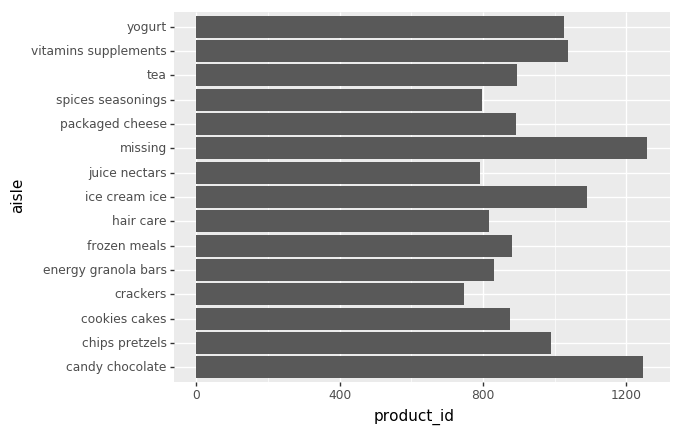

<ggplot: (-9223363280489720944)>

In [11]:
# 각 aisle에 상품이 몇 개씩 있는가 -> 상품이 많으면 그 aisle이 쇼핑 목록에 들어갈 확률이 높아진다.
(
    ggplot(part_aisle, aes('aisle', 'product_id'))
     +geom_bar(stat='identity')
     +coord_flip()
)

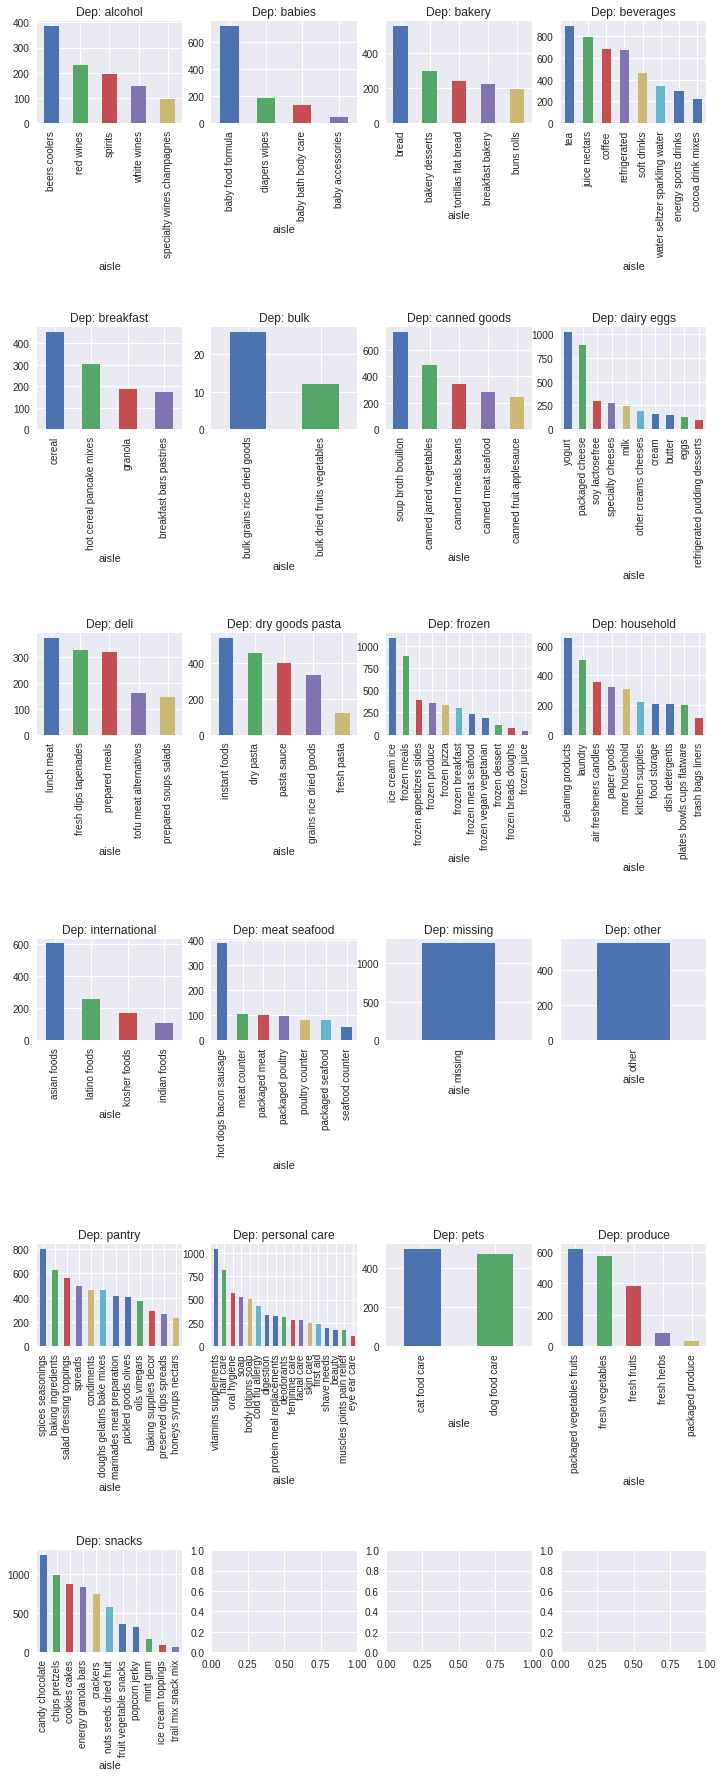

In [12]:
# 한 커널에서 참고 -> https://www.kaggle.com/frednavruzov/instacart-exploratory-data-analysis
# 각 department 내에서 다시 aisle 별로 구분하여 상품의 개수가 몇개인지 표현
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

In [7]:
from functools import partial

prior_detail = pd.merge(left=prior_df, 
                        right=order_products_prior,
                       how='left', on='order_id').apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

prior_detail = pd.merge(left=prior_detail,
                       right=goods[['product_id', 'aisle_id', 'department_id']],
                       how='left',
                       on='product_id').apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

In [8]:
# prior detail이 너무 커서 sample 500개만 추출->order_detail 만들기 위한 sample
prior_detail_sample1 = prior_detail.sample(500)

In [9]:
# order_detail_sample 만들기 위해 조금 더 추출하기로 한다
prior_detail_sample2 = prior_detail.sample(10000)

In [10]:
from functools import partial

train_detail = pd.merge(left=train_df, 
                        right=order_products_train,
                       how='left', on='order_id')

train_detail = pd.merge(left=train_detail,
                       right=goods[['product_id', 'aisle_id', 'department_id']],
                       how='left',
                       on='product_id')

In [11]:
# order_detail_sample 만들기 위해 train data도 sample 추출
train_detail_sample = train_detail.sample(10000)

In [12]:
#orders 있던 것처럼 test data만 빼고 prior sample + train
order_detail = pd.concat([prior_detail_sample1, train_detail], axis=0)
order_detail = order_detail.reset_index()

In [13]:
order_detail_sample = pd.concat([prior_detail_sample2, train_detail_sample],axis=0)
order_detail_sample = order_detail_sample.reset_index()

In [14]:
order_detail.head()

,index,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,10993114,1289332,69636,6,1,8,6.0,47209,2,1,24,4
1,31427142,223451,199727,12,0,15,9.0,41844,4,0,121,14
2,13569110,537216,85873,10,1,7,30.0,47209,6,0,24,4
3,19725363,1061273,125102,2,3,15,6.0,9208,3,0,52,1
4,18110370,2239416,114586,10,3,9,9.0,33000,10,0,36,16


In [18]:
top = (train_detail.groupby('product_id')
.size()
.sort_values(ascending=False)[:10]
)

In [19]:
top

product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
dtype: int64

....또 합치기 싫어서 하나씩 다 썼습니다.....ㅎ 10개만 하면 되니까요!.....ㅠ

In [20]:
number=['18276', '15480', '10894', '9784', '8135', '7409', '7293', '6494', '6033', '5546']
product_name=['banana', 'bag of organic bananas', 'organic strawberries', 'organic baby spinach', 'large lemon', 'organic avocado', 'organic hass avocado', 'strawberries', 'limes', 'organic rasberries'] 
top10_product = pd.DataFrame(number, product_name).reset_index()
top10_product.columns = ['product_name', 'number']

In [21]:
top10_product

,product_name,number
0,banana,18276
1,bag of organic bananas,15480
2,organic strawberries,10894
3,organic baby spinach,9784
4,large lemon,8135
5,organic avocado,7409
6,organic hass avocado,7293
7,strawberries,6494
8,limes,6033
9,organic rasberries,5546


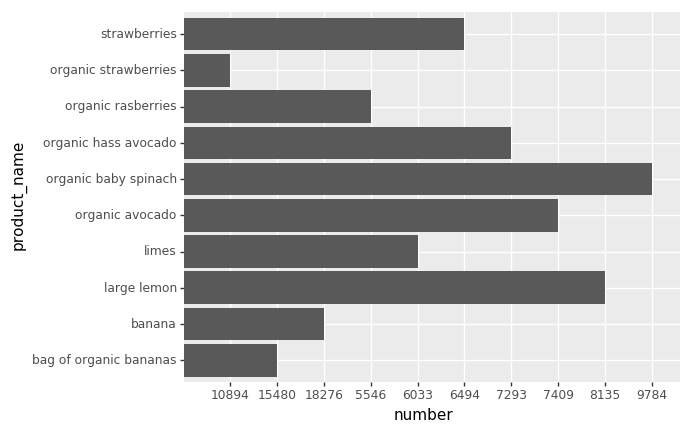

<ggplot: (-9223363280489762069)>

In [22]:
# 가장 판매량이 많은 상위 10개 상품
(
    ggplot(top10_product, aes('product_name', 'number'))
    +geom_bar(stat='identity')
    +coord_flip()
)

In [23]:
order_detail['aisle_id'].value_counts().head(10)

83     150656
24     150534
123     78520
120     55271
21      41719
115     36631
84      32658
107     31282
91      26250
112     23642
Name: aisle_id, dtype: int64

In [24]:
pop_aisle = ['fresh vegetables', 'fresh fruits', 'packaged vegetables fruits', 'yogurt', 'packaged cheese'
             , 'water seltzer sparkling water', 'milk', 'chips pretzels', 'soy lactosefree', 'bread']
num_aisle = ['150658', '150527', '78529', '55267', '41709' ,'36635', '32662', '31282', '26248', '23647']
top10_aisle = pd.DataFrame(num_aisle, pop_aisle).reset_index()
top10_aisle.columns = ['pop_aisle', 'num_aisle']

In [25]:
top10_aisle

,pop_aisle,num_aisle
0,fresh vegetables,150658
1,fresh fruits,150527
2,packaged vegetables fruits,78529
3,yogurt,55267
4,packaged cheese,41709
5,water seltzer sparkling water,36635
6,milk,32662
7,chips pretzels,31282
8,soy lactosefree,26248
9,bread,23647


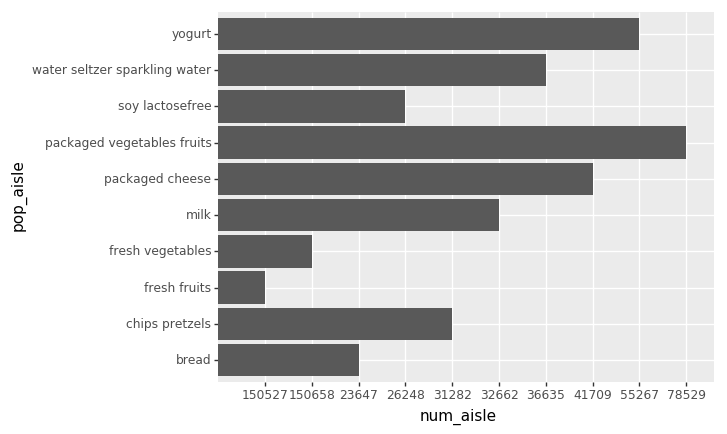

<ggplot: (8756226906162)>

In [26]:
# 가장 판매량이 많은 상위 10개 aisle
(
    ggplot(top10_aisle, aes('pop_aisle', 'num_aisle'))
    +geom_bar(stat='identity')
    +coord_flip()
)

In [27]:
order_detail['department_id'].value_counts().head(10)

4     409232
16    217153
19    118898
7     114090
1     100450
13     81267
3      48408
15     46814
20     44313
9      38728
Name: department_id, dtype: int64

In [28]:
pop_dep = ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry', 'bakery', 'canned goods', 'deli', 'dry goods pasta']
num_dep = ['409236', '217138', '118912', '114085', '100455', '81265', '48413', '46814', '44308', '38727']
top10_department = pd.DataFrame(num_dep, pop_dep).reset_index()
top10_department.columns = ['pop_dep', 'num_dep']

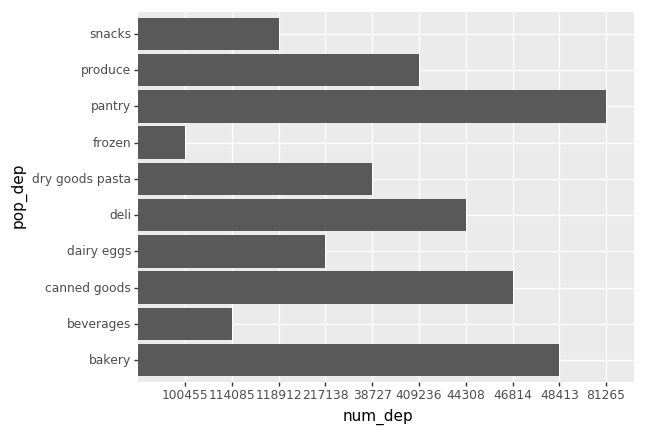

<ggplot: (-9223363280628434856)>

In [29]:
# 가장 판매량 많은 상위 10개 department
(
    ggplot(top10_department, aes('pop_dep', 'num_dep'))
    +geom_bar(stat='identity')
    +coord_flip()
)

In [30]:
num_order = (order_detail.groupby("order_id")["add_to_cart_order"]
 .aggregate(np.max).reset_index()['add_to_cart_order'].value_counts().to_frame().reset_index())

In [31]:
#근데 한번 주문에 100개가 넘는게 말이 되나....?
num_order

,index,add_to_cart_order
0,5,8931
1,6,8756
2,7,8563
3,4,8264
4,3,8069
5,8,8012
6,2,7411
7,9,7238
8,1,6911
9,10,6575


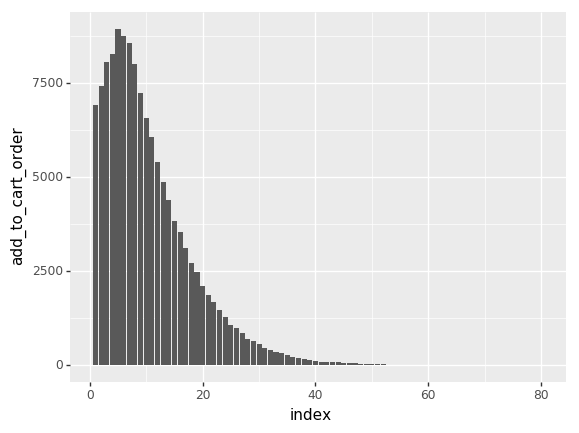

<ggplot: (-9223363280489929412)>

In [32]:
# 한 번 주문할 때 몇 개의 상품을 주문하는가
#여기서 x축 index는 한번에 주문한 상품의 갯수, y축 add_to_cart_order는 그 갯수만큼 주문이 몇 번 들어왔는가
#각 숫자가 정확히 안떠서 커프링스가 더 나은듯 (커프링스는 커서 갖다 대면 정확한 숫자를 보여주기 때문)
(
    ggplot(num_order, aes('index', 'add_to_cart_order'))
    +geom_bar(stat='identity')
)

In [33]:
day = orders.groupby('order_dow').size().sort_values().to_frame().reset_index()
day.columns = ['order_dow', 'orders']
day

,order_dow,orders
0,4,426339
1,3,436972
2,6,448761
3,5,453368
4,2,467260
5,1,587478
6,0,600905


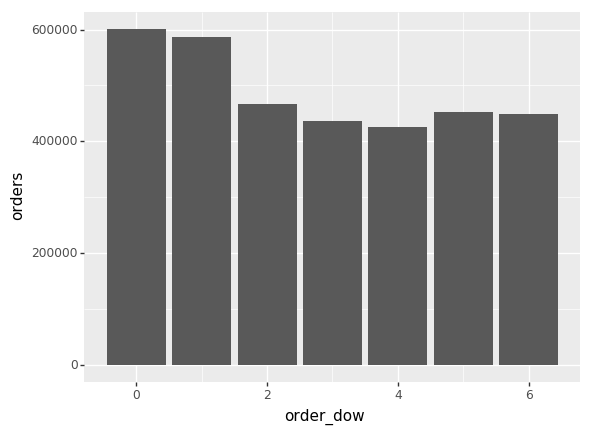

<ggplot: (-9223363280489826202)>

In [34]:
#무슨 요일에 주문이 많이 들어오는지 -> 거의 비슷한데 0,1로 표시된 이틀의 주문량이 가장 많음. 아마 주말일 것으로 예상
(
    ggplot(day, aes('order_dow', 'orders'))
    +geom_bar(stat='identity')
)

In [35]:
hour = orders.groupby('order_hour_of_day').size().sort_values().to_frame().reset_index()
hour.columns = ['order_hour_of_day', 'orders']
hour

,order_hour_of_day,orders
0,3,5474
1,4,5527
2,2,7539
3,5,9569
4,1,12398
5,0,22758
6,6,30529
7,23,40043
8,22,61468
9,21,78109


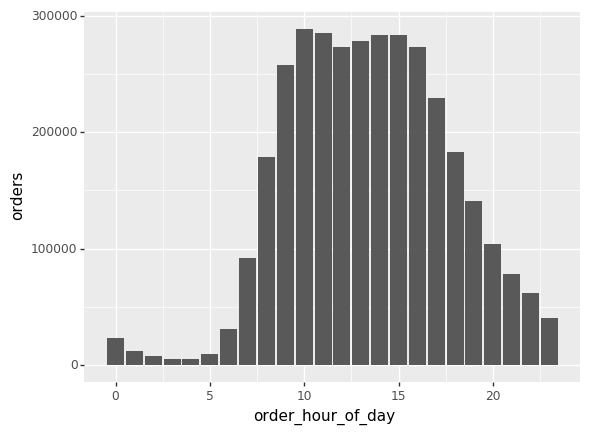

<ggplot: (8756365631180)>

In [36]:
# 무슨 시간대에 주문이 많이 들어오는지 -> 낮~오후(약 9시~17시) 시간대에 주문량이 많다.
(
    ggplot(hour, aes('order_hour_of_day', 'orders'))
    +geom_bar(stat='identity')
)

In [37]:
days_after = orders.groupby('days_since_prior_order').size().sort_values().to_frame().reset_index()
days_after.columns = ['days_since_prior_order', 'orders']
days_after

,days_since_prior_order,orders
0,26.0,19016
1,29.0,19191
2,25.0,19234
3,24.0,20712
4,27.0,22013
5,23.0,23885
6,28.0,26777
7,22.0,32012
8,19.0,34384
9,18.0,35881


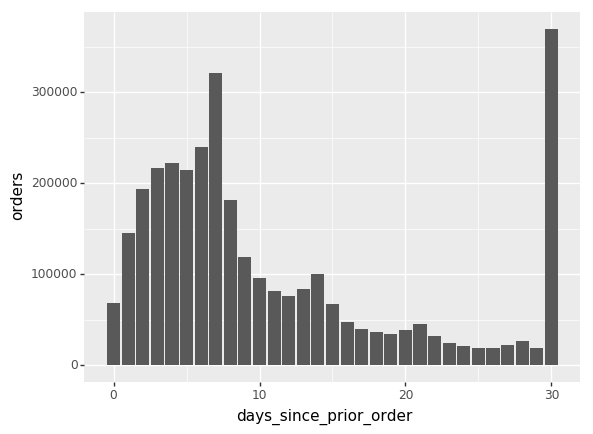

<ggplot: (8756364768702)>

In [38]:
# 재구매는 이전 주문으로부터 몇일 이후 가장 많은가 
# -> 주로 10일 이전에 많이 주문을 하지만, 단독 날짜로 보았을 때는 한 달 이후 주문 했을 때 주문량이 가장 많다.
(
    ggplot(days_after, aes('days_since_prior_order', 'orders'))
    +geom_bar(stat='identity')
)

사실 결국 구하고 싶은 것은 '소비자가 어떤 상품을 구매할 것인가'이다. 따라서 어떤 상품을 구매했었는지를 바탕으로 미래의 소비를 예측해야 한다. 

이에 따라 '재구매 비율'을 새로운 종속변수로 두고 각 독립변수와의 관계 비교해보려고 한다.

In [39]:
order_detail.head()

,index,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,4934220,2606055,31432,5,1,8,27.0,27801,5,1,108,16
1,26032575,237104,165365,61,5,16,6.0,1710,13,1,31,7
2,14026848,600545,88830,6,3,11,4.0,40706,6,1,123,4
3,5731059,2348164,36481,80,2,11,2.0,46847,4,1,130,14
4,2564297,489135,16431,15,1,12,7.0,31714,4,0,21,16


In [40]:
hour_reorder = order_detail.groupby(['order_hour_of_day','reordered']).size().unstack()
hour_reorder['reorder_ratio'] = hour_reorder[1.0]/(hour_reorder[1.0]+hour_reorder[0.0])
hour_reorder=hour_reorder.reset_index()
hour_reorder.head()

reordered,order_hour_of_day,0,1,reorder_ratio
0,0,3896,5189,0.571161
1,1,2366,3260,0.579453
2,2,1357,1870,0.579486
3,3,1020,1418,0.581624
4,4,977,1455,0.598273


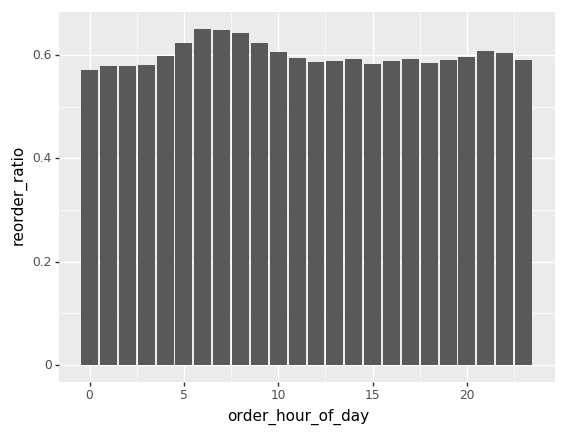

<ggplot: (8756226317544)>

In [41]:
#order_hour_of_day와 비교 -> 5시~10시 사이에 재구매 비율이 조금 올라간다
(
    ggplot(hour_reorder, aes('order_hour_of_day', 'reorder_ratio'))
    +geom_bar(stat='identity')
)

In [42]:
dow_reorder = order_detail.groupby(['order_dow','reordered']).size().unstack()
dow_reorder['reorder_ratio'] = dow_reorder[1.0]/(dow_reorder[1.0]+dow_reorder[0.0])
dow_reorder=dow_reorder.reset_index()
dow_reorder.head()

reordered,order_dow,0,1,reorder_ratio
0,0,126536,197597,0.609617
1,1,82638,123435,0.598987
2,2,66125,94508,0.588347
3,3,63823,90617,0.586746
4,4,63049,92484,0.594626


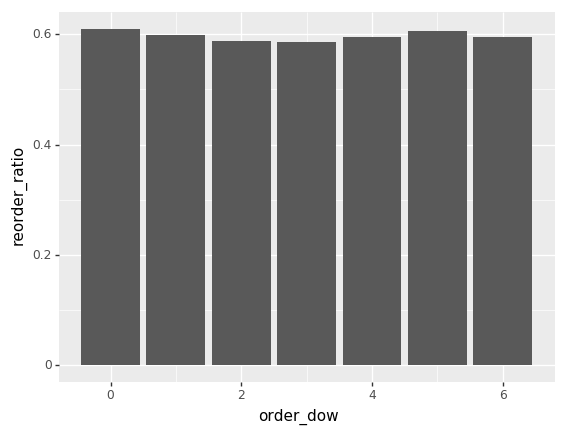

<ggplot: (-9223363280628482991)>

In [43]:
#order_dow와 비교 -> 요일이 재구매에 미치는 영향은 그리 크지 않음
(
    ggplot(dow_reorder, aes('order_dow', 'reorder_ratio'))
    +geom_bar(stat='identity')
)

In [44]:
days_reorder = order_detail.groupby(['days_since_prior_order','reordered']).size().unstack()
days_reorder['reorder_ratio'] = days_reorder[1.0]/(days_reorder[1.0]+days_reorder[0.0])
days_reorder=days_reorder.reset_index()
days_reorder.head()

reordered,days_since_prior_order,0,1,reorder_ratio
0,0.0,2998,14055,0.824195
1,1.0,7418,11856,0.615129
2,2.0,10468,17059,0.619719
3,3.0,12687,23893,0.653171
4,4.0,14853,30907,0.675415


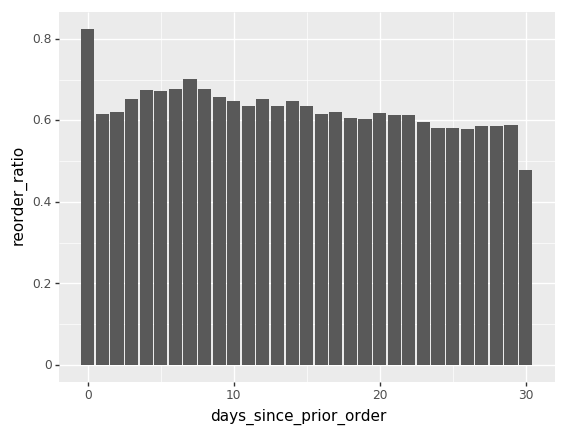

<ggplot: (-9223363280628527686)>

In [45]:
#days_since_prior_order와 비교 -> x축이 0인 것은 첫 구매이기 때문에 비율이 당연?.....
(
    ggplot(days_reorder, aes('days_since_prior_order', 'reorder_ratio'))
    +geom_bar(stat='identity')
)

In [46]:
add_reorder = order_detail.groupby(['add_to_cart_order','reordered']).size().unstack()
add_reorder['reorder_ratio'] = add_reorder[1.0]/(add_reorder[1.0]+add_reorder[0.0])
add_reorder=add_reorder.reset_index()
add_reorder.head()

reordered,add_to_cart_order,0,1,reorder_ratio
0,1,36415,94860,0.722605
1,2,37467,86940,0.698835
2,3,38858,78174,0.667971
3,4,38484,70525,0.646965
4,5,38012,62769,0.622826


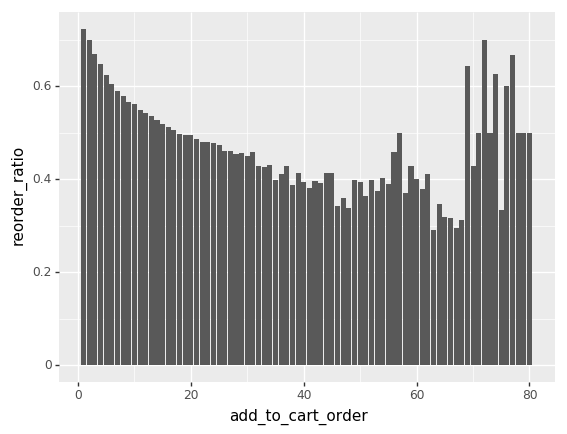

<ggplot: (8756226233804)>

In [47]:
#days_since_prior_order와 비교 -> 40개 전까지는 담는 순서 뒤로 갈수록 재구매 비율 떨어짐, 
#70개 이상부터 갑자기 재구매 비율 올라감... 그런데 이전에도 언급했듯이 한번에 저렇게 많은 구매를 하기도 하는지 의문이 듦
#하여튼 아예 관련 없는 변수는 아닌듯 하다.
(
    ggplot(add_reorder, aes('add_to_cart_order', 'reorder_ratio'))
    +geom_bar(stat='identity')
)

## 2. Feature Engineering

In [15]:
order_detail.head()

,index,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,10993114,1289332,69636,6,1,8,6.0,47209,2,1,24,4
1,31427142,223451,199727,12,0,15,9.0,41844,4,0,121,14
2,13569110,537216,85873,10,1,7,30.0,47209,6,0,24,4
3,19725363,1061273,125102,2,3,15,6.0,9208,3,0,52,1
4,18110370,2239416,114586,10,3,9,9.0,33000,10,0,36,16


In [16]:
Order_detail = order_detail

department_id, aisle_id 제거 -> product_id가 이 정보를 다 담고 있기 때문

order_dow 제거 -> 위에 EDA한 바와 같이 요일은 재구매에 큰 영향을 미치지 못한다.

In [17]:
Order_detail = Order_detail.drop(['order_dow', 'department_id', 'aisle_id'], axis=1)

In [18]:
Order_detail.head()

,index,order_id,user_id,order_number,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,10993114,1289332,69636,6,8,6.0,47209,2,1
1,31427142,223451,199727,12,15,9.0,41844,4,0
2,13569110,537216,85873,10,7,30.0,47209,6,0
3,19725363,1061273,125102,2,15,6.0,9208,3,0
4,18110370,2239416,114586,10,9,9.0,33000,10,0


order_hour_of_day / days_since_prior order 구획 짓기, 즉 범주형 변수처럼 바꾸기

reorder ratio에 따라 구획을 지으면 좋겠지만 사실 크게 차이가 나지 않고, 범주로 나누기도 애매함. 먼저 EDA한 그래프에 따라 주문량을 가지고 구획을 지을 것이다. 숫자가 높을수록 해당 product가 구매될 확률이 높다는 뜻이다.

In [19]:
#hour 구획 -> 주문량이 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
c = Order_detail['order_hour_of_day'].tolist()

d = []

hour1 = [9,10,11,12,13,14,15,16,17]
hour2 = [8,18,19,20]

for x in c:
    if x in hour1:
        d.append(2)
    elif x in hour2:
        d.append(1)
    else:
        d.append(0)
        
Order_detail['re-hour'] = d

In [20]:
#days since prior order 구획 -> 주문량이 30만 이상이면 3, 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
e = Order_detail['days_since_prior_order'].tolist()

f = []

day1=[7,30]
day2=[3,4,5,6]
day3=[1,2,9]

for x in e:
    if x in day1:
        f.append(3)
    elif x in day2:
        f.append(2)
    elif x in day3:
        f.append(1)
    else:
        f.append(0)
        
Order_detail['re-after days'] = f

In [21]:
Order_detail = Order_detail.drop(['order_hour_of_day', 'days_since_prior_order'], axis=1)

In [22]:
Order_detail.head()

,index,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,re-hour,re-after days
0,10993114,1289332,69636,6,47209,2,1,1,2
1,31427142,223451,199727,12,41844,4,0,2,1
2,13569110,537216,85873,10,47209,6,0,0,3
3,19725363,1061273,125102,2,9208,3,0,2,2
4,18110370,2239416,114586,10,33000,10,0,2,1


In [23]:
Test_df = test_df

In [24]:
#hour 구획 -> 주문량이 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
c = Test_df['order_hour_of_day'].tolist()

d = []

hour1 = [9,10,11,12,13,14,15,16,17]
hour2 = [8,18,19,20]

for x in c:
    if x in hour1:
        d.append(2)
    elif x in hour2:
        d.append(1)
    else:
        d.append(0)
        
Test_df['re-hour'] = d

In [25]:
#days since prior order 구획 -> 주문량이 30만 이상이면 3, 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
e = Test_df['days_since_prior_order'].tolist()

f = []

day1=[7,30]
day2=[3,4,5,6]
day3=[1,2,9]

for x in e:
    if x in day1:
        f.append(3)
    elif x in day2:
        f.append(2)
    elif x in day3:
        f.append(1)
    else:
        f.append(0)
        
Test_df['re-after days'] = f

In [26]:
Test_df = Test_df.drop(['order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis=1)

In [27]:
Test_df.head()

,order_id,user_id,order_number,re-hour,re-after days
0,2774568,3,13,2,0
1,329954,4,6,2,3
2,1528013,6,4,2,0
3,1376945,11,8,2,0
4,1356845,12,6,1,3


'전체 사람이 재구매를 많이 했다면 개인도 재구매할 확률이 높을 것이다'라는 가정 하에 product별 reordered 비율을 구한다.


하지만 Order_detail data는 train_detail을 sample(500)했기 때문에 모든 데이터에 대한 정보가 없음. 결국 전체 데이터 합치고 해보기...

In [28]:
full_detail = pd.concat([train_detail, prior_detail], axis=0)

In [29]:
full_detail.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,1187899,1,11,4,8,14.0,196,1,1,77,7
1,1187899,1,11,4,8,14.0,25133,2,1,21,16
2,1187899,1,11,4,8,14.0,38928,3,1,120,16
3,1187899,1,11,4,8,14.0,26405,4,1,54,17
4,1187899,1,11,4,8,14.0,39657,5,1,45,19


In [30]:
reorder_ratio = full_detail.groupby('product_id')['reordered'].mean().to_frame().reset_index()

In [31]:
reorder_ratio.columns = ['product_id', 'reordered_ratio']
reorder_ratio.head(20)

,product_id,reordered_ratio
0,1,0.614627
1,2,0.138298
2,3,0.738516
3,4,0.458689
4,5,0.625000
5,6,0.375000
6,7,0.419355
7,8,0.505618
8,9,0.521739
9,10,0.510591


full_detail data에 Order_detail에 해줬던 feature engineering을 다시 한다. 처음부터 이렇게 했으면 좋았을 것을ㅠ

In [32]:
Full_detail = full_detail

In [33]:
Full_detail = Full_detail.drop(['order_dow', 'department_id', 'aisle_id'], axis=1)

In [34]:
#hour 구획 -> 주문량이 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
c = Full_detail['order_hour_of_day'].tolist()

d = []

hour1 = [9,10,11,12,13,14,15,16,17]
hour2 = [8,18,19,20]

for x in c:
    if x in hour1:
        d.append(2)
    elif x in hour2:
        d.append(1)
    else:
        d.append(0)
        
Full_detail['re-hour'] = d

In [35]:
#days since prior order 구획 -> 주문량이 30만 이상이면 3, 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
e = Full_detail['days_since_prior_order'].tolist()

f = []

day1=[7,30]
day2=[3,4,5,6]
day3=[1,2,9]

for x in e:
    if x in day1:
        f.append(3)
    elif x in day2:
        f.append(2)
    elif x in day3:
        f.append(1)
    else:
        f.append(0)
        
Full_detail['re-after days'] = f

In [36]:
Full_detail = Full_detail.drop(['order_hour_of_day', 'days_since_prior_order'], axis=1)

In [37]:
Full_detail = pd.merge(left=Full_detail, right=reorder_ratio, how='left')

In [38]:
Full_detail.head()

,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,re-hour,re-after days,reordered_ratio
0,1187899,1,11,196,1,1,1,0,0.777843
1,1187899,1,11,25133,2,1,1,0,0.740364
2,1187899,1,11,38928,3,1,1,0,0.826826
3,1187899,1,11,26405,4,1,1,0,0.453374
4,1187899,1,11,39657,5,1,1,0,0.768094


In [39]:
order_detail_sample = order_detail_sample.drop(['order_dow', 'department_id', 'aisle_id'], axis=1)

In [40]:
#hour 구획 -> 주문량이 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
c = order_detail_sample['order_hour_of_day'].tolist()

d = []

hour1 = [9,10,11,12,13,14,15,16,17]
hour2 = [8,18,19,20]

for x in c:
    if x in hour1:
        d.append(2)
    elif x in hour2:
        d.append(1)
    else:
        d.append(0)
        
order_detail_sample['re-hour'] = d


In [41]:
#days since prior order 구획 -> 주문량이 30만 이상이면 3, 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
e = order_detail_sample['days_since_prior_order'].tolist()

f = []

day1=[7,30]
day2=[3,4,5,6]
day3=[1,2,9]

for x in e:
    if x in day1:
        f.append(3)
    elif x in day2:
        f.append(2)
    elif x in day3:
        f.append(1)
    else:
        f.append(0)
        
order_detail_sample['re-after days'] = f


In [42]:
order_detail_sample = order_detail_sample.drop(['order_hour_of_day', 'days_since_prior_order'], axis=1)

In [43]:
order_detail_sample = pd.merge(left=order_detail_sample, right=reorder_ratio, how='left')

In [44]:
order_detail_sample.head()

,index,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,re-hour,re-after days,reordered_ratio
0,10243998,2398583,65195,1,23485,9,0,2,0,0.636986
1,1605682,1754823,10379,47,27531,6,1,0,0,0.656709
2,21251331,1507391,135003,31,46802,2,1,2,2,0.573981
3,16096266,2034279,101798,16,20431,11,0,0,0,0.487687
4,11146076,1542923,70619,30,49235,11,1,1,3,0.782232


# 3. Modeling

Full_detail data에서 'reordered'를 종속변수로 두고 모델링을 시작한다. 사용할 독립변수는 'user_id', 'product_id', 'reordered_ratio', 're-hour 더미 변수들', 're-after days 더미 변수들'이다.

진짜 test_df를 가지고 구매 여부를 판단하기 위해서는 test_df data에 모든 product_id, 각각의 reordered_ratio를 넣어 새로운 dataframe을 만들어야 한다. 물론 order_hour와 days_since_prior_order를 범주화하고 더미화 해주는 것도 잊지 않아야 한다.

xgboost와 adaboost, random forest, 그리고 logistic regression의 네가지 모델을 스태킹하여 classify하려고 한다.

In [45]:
Full_detail = pd.get_dummies(Full_detail, columns=['re-hour', 're-after days'])

In [46]:
Full_detail.head()

,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,reordered_ratio,re-hour_0,re-hour_1,re-hour_2,re-after days_0,re-after days_1,re-after days_2,re-after days_3
0,1187899,1,11,196,1,1,0.777843,0,1,0,1,0,0,0
1,1187899,1,11,25133,2,1,0.740364,0,1,0,1,0,0,0
2,1187899,1,11,38928,3,1,0.826826,0,1,0,1,0,0,0
3,1187899,1,11,26405,4,1,0.453374,0,1,0,1,0,0,0
4,1187899,1,11,39657,5,1,0.768094,0,1,0,1,0,0,0


Logistic Regression을 사용할 것이기 때문에 다중공선성을 막기 위해 더미 변수들 중 하나를 아예 지워준다.

In [47]:
Full_detail = Full_detail.drop(['re-hour_2', 're-after days_3'], axis=1)

In [48]:
Full_detail.head()

,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,reordered_ratio,re-hour_0,re-hour_1,re-after days_0,re-after days_1,re-after days_2
0,1187899,1,11,196,1,1,0.777843,0,1,1,0,0
1,1187899,1,11,25133,2,1,0.740364,0,1,1,0,0
2,1187899,1,11,38928,3,1,0.826826,0,1,1,0,0
3,1187899,1,11,26405,4,1,0.453374,0,1,1,0,0
4,1187899,1,11,39657,5,1,0.768094,0,1,1,0,0


In [29]:
!pip install xgboost

    100% |████████████████████████████████| 460kB 547kB/s ta 0:00:01
  Running setup.py bdist_wheel for xgboost ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/ca/b3/02/d44d5e12c5c1eecff4a822555bac96b182551cd5e13c4795f6
Successfully built xgboost


In [38]:
!pip install vecstack

  Running setup.py bdist_wheel for vecstack ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/63/47/0e17879e8b3c83063f5c452535b931ad812bf72b98b3089c7e
Successfully built vecstack


In [49]:
from sklearn import model_selection, metrics
from sklearn.cross_validation import cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import GridSearchCV
from vecstack import stacking

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
#스코어 측정
from sklearn.metrics import auc, f1_score, accuracy_score
my_scorer = metrics.make_scorer(accuracy_score, greater_is_better = True)

In [39]:
feature_cols = ['user_id', 'product_id', 'reordered_ratio', 're-hour_0', 're-hour_1', 're-after days_0', 're-after days_1', 're-after days_2']
X = Full_detail[feature_cols] 
y = Full_detail['reordered']

In [31]:
len(Full_detail['user_id'])

33819106

원래는 Full_detail로 돌려야 하는데........도저히 시간이 지나도 최적의 파라미터를 구할 수가 없다....... 결과를 낼 수가 없어요!....

결국 어쩔 수 없이 Order_detail로 돌려서 약식의 결과를 알아보아야 할 것 같다.

In [51]:
Order_detail = pd.merge(left=Order_detail, right=reorder_ratio, how='left')

In [52]:
Order_detail = pd.get_dummies(Order_detail, columns=['re-hour', 're-after days'])

In [53]:
Order_detail.head()

,index,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,reordered_ratio,re-hour_0,re-hour_1,re-hour_2,re-after days_0,re-after days_1,re-after days_2,re-after days_3
0,10993114,1289332,69636,6,47209,2,1,0.797607,0,1,0,0,0,1,0
1,31427142,223451,199727,12,41844,4,0,0.573804,0,0,1,0,1,0,0
2,13569110,537216,85873,10,47209,6,0,0.797607,1,0,0,0,0,0,1
3,19725363,1061273,125102,2,9208,3,0,0.755435,0,0,1,0,0,1,0
4,18110370,2239416,114586,10,33000,10,0,0.658490,0,0,1,0,1,0,0


In [54]:
Order_detail = Order_detail.drop(['re-hour_2', 're-after days_3'], axis=1)

In [55]:
Order_detail.head()

,index,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,reordered_ratio,re-hour_0,re-hour_1,re-after days_0,re-after days_1,re-after days_2
0,10993114,1289332,69636,6,47209,2,1,0.797607,0,1,0,0,1
1,31427142,223451,199727,12,41844,4,0,0.573804,0,0,0,1,0
2,13569110,537216,85873,10,47209,6,0,0.797607,1,0,0,0,0
3,19725363,1061273,125102,2,9208,3,0,0.755435,0,0,0,0,1
4,18110370,2239416,114586,10,33000,10,0,0.658490,0,0,0,1,0


In [35]:
feature_cols = ['user_id', 'product_id', 'reordered_ratio', 're-hour_0', 're-hour_1', 're-after days_0', 're-after days_1', 're-after days_2']
X = Order_detail[feature_cols] 
y = Order_detail['reordered']

In [42]:
len(Order_detail['user_id'])

1385117

.....그런데 row 1385117개의 Order_detail도 안돌아감ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

일단 order_detail_sample 데이터만 가지고 최적의 파라미터를 찾는다

In [56]:
order_detail_sample = pd.get_dummies(order_detail_sample, columns=['re-hour', 're-after days'])

In [57]:
order_detail_sample = order_detail_sample.drop(['re-hour_2', 're-after days_3'], axis=1)

In [58]:
order_detail_sample.head()

,index,order_id,user_id,order_number,product_id,add_to_cart_order,reordered,reordered_ratio,re-hour_0,re-hour_1,re-after days_0,re-after days_1,re-after days_2
0,10243998,2398583,65195,1,23485,9,0,0.636986,0,0,1,0,0
1,1605682,1754823,10379,47,27531,6,1,0.656709,1,0,1,0,0
2,21251331,1507391,135003,31,46802,2,1,0.573981,0,0,0,0,1
3,16096266,2034279,101798,16,20431,11,0,0.487687,1,0,1,0,0
4,11146076,1542923,70619,30,49235,11,1,0.782232,0,1,0,0,0


In [84]:
feature_cols = ['user_id', 'product_id', 'reordered_ratio', 're-hour_0', 're-hour_1', 're-after days_0', 're-after days_1', 're-after days_2']
X = order_detail_sample[feature_cols] 
y = order_detail_sample['reordered']

In [36]:
#XGBoost parameter 설정
xgb_params = {
    'learning_rate' : [0.01, 0.05, 0.07, 0.1, 0.2],
    'n_estimators' : [n for n in range(80,200,20)]
}
xgb_grid = GridSearchCV(XGBClassifier(), param_grid=xgb_params, scoring=my_scorer, cv=5, verbose=1)
xgb_grid.fit(X, y)

print("Best Score : {}".format(xgb_grid.best_score_))
print("Best Params : {}".format(xgb_grid.best_params_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.7min finished


Best Score : 0.65075
Best Params : {'learning_rate': 0.07, 'n_estimators': 120}


In [37]:
#AdaBoost parameter 설정
ada_params = {
    'learning_rate' : [0.03, 0.07, 0.1],
    'n_estimators' : [n for n in range(80,130,20)]
}
ada_grid = GridSearchCV(AdaBoostClassifier(), param_grid=ada_params, scoring=my_scorer, cv=5, verbose=1)
ada_grid.fit(X, y)

print("Best Score : {}".format(ada_grid.best_score_))
print("Best Params : {}".format(ada_grid.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   52.0s finished


Best Score : 0.65145
Best Params : {'learning_rate': 0.03, 'n_estimators': 100}


In [71]:
#Random Forest parameter 설정
rf_params = {
    'max_depth' : [2,4,6],
    'n_estimators': [n for n in range(500, 1000, 2000)]
}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, scoring=my_scorer, cv=5, verbose=1)
rf_grid.fit(X,y)

print("Best Score : {}".format(rf_grid.best_score_))
print("Best Params : {}".format(rf_grid.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   30.4s finished


Best Score : 0.6478
Best Params : {'max_depth': 4, 'n_estimators': 500}


최적의 파라미터:

XGBClassifier(learning_rate=0.07, n_estimators=120),

AdaBoostClassifier(learning_rate=0.03, n_estimators=100),

RandomForestClassifier(max_depth=4, n_estimators=500)

현재 Full_detail에는 각 소비자가 구매한 상품들만 data에 포함되어있다. 구매하지 않은 상품들까지 row에 넣어 order라는 새로운 column을  0으로 채워주려 한다. (기존에 구매한 것들은 1이 될 것)

In [82]:
a = []
b = []

for i in Full_detail['user_id'].unique().tolist():
    for j in goods['product_id'].unique().tolist():
        if j not in Full_detail.groupby('user_id')['product_id'].unique().tolist()[i-1].tolist():
            a.append(i) # user_id
            b.append(j) # product_id
        else:
            pass

KeyboardInterrupt: 

그런데 2시간이 지나도 돌아가지 않는다ㅎㅎㅎㅎㅎㅎㅎㅎ

In [ ]:
feature_cols = ['user_id', 'product_id', 'reordered_ratio', 're-hour_0', 're-hour_1', 're-after days_0', 're-after days_1', 're-after days_2']
X = Full_detail[feature_cols] # row 새로 만든 것으로 정해야 함
y = Full_detail['reordered']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [86]:
# 이 결과는 Full_detail로 한 것이 아니라 order_detail_sample로 돌렸을 때의 결과입니다.

# Initialize 1st level models
models = [
    XGBClassifier(learning_rate=0.07, n_estimators=120),
    AdaBoostClassifier(learning_rate=0.03, n_estimators=100),
    RandomForestClassifier(max_depth=4, n_estimators=500)
]

# Compute stacking features
S_train, S_test = stacking(models, X_train, y_train, X_test, 
    regression = False, metric = accuracy_score, n_folds = 5, 
    stratified = True, shuffle = True, random_state = 0, verbose = 2)

# Initialize 2nd level model
model = LogisticRegression()
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Final prediction score
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

task:       [classification]
n_classes:  [2]
metric:     [accuracy_score]
mode:       [oof_pred_bag]
n_models:   [3]

model 0:    [XGBClassifier]
    fold 0: [0.65198376]
    fold 1: [0.64250000]
    fold 2: [0.64031250]
    fold 3: [0.64312500]
    fold 4: [0.64770241]
    ----
    MEAN:   [0.64512473] + [0.00418895]
    FULL:   [0.64512500]

model 1:    [AdaBoostClassifier]
    fold 0: [0.65323336]
    fold 1: [0.64750000]
    fold 2: [0.63968750]
    fold 3: [0.64281250]
    fold 4: [0.64207565]
    ----
    MEAN:   [0.64506180] + [0.00480789]
    FULL:   [0.64506250]

model 2:    [RandomForestClassifier]
    fold 0: [0.65417057]
    fold 1: [0.64187500]
    fold 2: [0.64406250]
    fold 3: [0.64093750]
    fold 4: [0.65051579]
    ----
    MEAN:   [0.64631227] + [0.00515871]
    FULL:   [0.64631250]

Final prediction score: [0.65325000]


결국...제출은 하지 못했고......... sample로만 모델링 해본 예측값만 제출합니다....죄송합니다ㅠ

Reference

https://www.kaggle.com/frednavruzov/instacart-exploratory-data-analysis

https://www.kaggle.com/philippsp/exploratory-analysis-instacart

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart

https://github.com/vecxoz/vecstack